In [1]:
import pandas as pd
import numpy as np
import sqlite3
from matplotlib import pyplot as plt
import pystan
import arviz

# Set default figure size
plt.rcParams["figure.figsize"] = (15, 10)

In [13]:
conn = sqlite3.Connection('data.db')
spx_data = pd.read_sql("SELECT * FROM prices WHERE ticker='^GSPC'", conn, index_col='date', parse_dates='date')
spx_returns = np.log(spx_data['close']) - np.log(spx_data['close'].shift(1))
spx_returns = spx_returns.dropna()

In [18]:
model_spec = '''
data {
    int len;
    vector[len] returns;
}
parameters {
    real mu;
    real<lower=-1, upper=1> phi;
    real<lower=0> sigma;
    vector[len] h_std;
}
transformed parameters {
    vector[len] h = h_std * sigma;          // Now normal(0, sigma)
    h[1] /= sqrt(1 - phi^2);                // Scale h[1]
    h += mu;                                // Now normal(mu, sigma)
    for (t in 2:len) {                      // Apply phi autoregression
        h[t] += phi * (h[t-1] - mu);
    }
}
model {
    phi ~ uniform(-1, 1);
    sigma ~ cauchy(0, 5);
    mu ~ cauchy(0, 10);
    h_std ~ std_normal();
    returns ~ normal(0, exp(h/2));
}
'''

In [19]:
model = pystan.StanModel(model_code=model_spec)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ec3d416b1f620420f47eb37f15061c1a NOW.


In [20]:
params = {'len': len(spx_returns), 'returns': spx_returns}

sample = model.sampling(data=params, chains=4, warmup=250, iter=1500)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [21]:
arviz_data = arviz.from_pystan(
    posterior=sample
)

array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'phi'}>,
        <AxesSubplot:title={'center':'phi'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

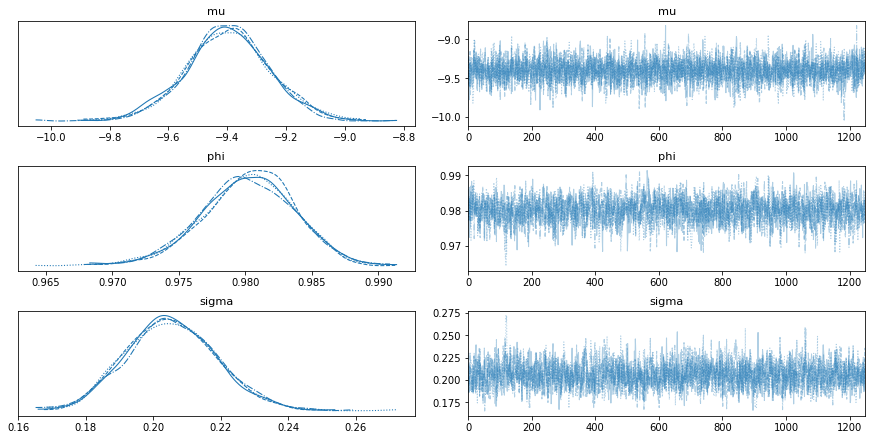

In [22]:
arviz.plot_trace(arviz_data, var_names=['mu', 'phi', 'sigma'])

In [222]:
output = np.zeros((5000, 1000))

sample_data = sample.extract()
h = sample_data['h'][:, -1]
phi = sample_data['phi']
sigma = sample_data['sigma']
mu = sample_data['mu']

for t in range(1000):
    vol_resids = sigma * np.random.randn(5000)
    forward_vol = mu + phi * (h_prev - mu) + vol_resids
    output[:, t] = forward_vol
    h_prev = forward_vol

output = np.exp(output / 2)

In [247]:
length = len(spx_returns)
warmup = 252
oos_periods = 7
iterations = (length - warmup) // oos_periods
new_warmup = warmup + (length - warmup) % 7

In [254]:
for t in range(iterations):
    print(new_warmup + (t * 7))

255
262
269
276
283
290
297
304
311
318
325
332
339
346
353
360
367
374
381
388
395
402
409
416
423
430
437
444
451
458
465
472
479
486
493
500
507
514
521
528
535
542
549
556
563
570
577
584
591
598
605
612
619
626
633
640
647
654
661
668
675
682
689
696
703
710
717
724
731
738
745
752
759
766
773
780
787
794
801
808
815
822
829
836
843
850
857
864
871
878
885
892
899
906
913
920
927
934
941
948
955
962
969
976
983
990
997
1004
1011
1018
1025
1032
1039
1046
1053
1060
1067
1074
1081
1088
1095
1102
1109
1116
1123
1130
1137
1144
1151
1158
1165
1172
1179
1186
1193
1200
1207
1214
1221
1228
1235
1242
1249
1256
1263
1270
1277
1284
1291
1298
1305
1312
1319
1326
1333
1340
1347
1354
1361
1368
1375
1382
1389
1396
1403
1410
1417
1424
1431
1438
1445
1452
1459
1466
1473
1480
1487
1494
1501
1508
1515
1522
1529
1536
1543
1550
1557
1564
1571
1578
1585
1592
1599
1606
1613
1620
1627
1634
1641
1648
1655
1662
1669
1676
1683
1690
1697
1704
1711
1718
1725
1732
1739
1746
1753
1760
1767
1774
1781
1788
1795
18